# Basic Pytorch Concepts in practice by building MNIST CNN model

## 1. Load Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm
import os
import random

%reload_ext autoreload
%autoreload 2
%matplotlib inline

## 2. Read / Import Data

In [2]:
BATCH_SIZE = 32 # or 64, 128

## transform the data into 'tensors' using the 'transforms' module
transform = transforms.Compose(
    [transforms.ToTensor()])

## download training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
## download testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.40MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.91MB/s]


## 3. Load Data on DataLoader

In [3]:
# Feed data in batches into deep-learning models
# num_workers=0 in Windows machine
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)

## 4. Explore the Data (EDA)

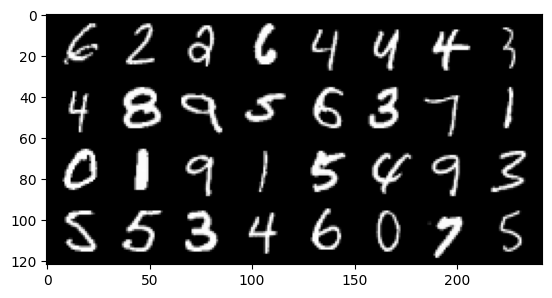

In [5]:
## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

## show images
imshow(torchvision.utils.make_grid(images))

In [6]:
## Check the dimensions of a batch:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


In [7]:
# Image batch dimensions: torch.Size([32, 1, 28, 28]) -->
# 32: samples, 1 color channel, 28 x 28 (height x width)
# Image label dimensions: torch.Size([32])

## 5. Create a model, optimizer and criterion

In [8]:
# The model below consists of an __init__() portion where you include the layers and components of the neural network.
# In our model, we have a convolutional layer denoted by nn.Conv2d(...).
# We are dealing with an image dataset that is in grayscale so we only need one channel going in, so "in_channels=1".
# We hope to get a nice representation of this layer, so we use "out_channels=32".
# Kernel size is 3, and for the rest of parameters, we use the default values which you can find here.

In [9]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128) # 128 represents the size we want as output, and (26*26*32) represents the dimension of the incoming data
        self.d2 = nn.Linear(128, 10) #  The same applies for the second dense layer (d2) where the dimension of the output of the previous linear layer was added as in_features=128,
        # and 10 is the size of the output (It should be same the final number of classes we want to predict)

        # To see how to calculate this, go to https://pytorch.org/docs/stable/nn.html?highlight=linear#conv2d

        # Apply an activation function such as ReLU in the middle of each layer
        # For prediction purposes, we then apply a softmax layer to the last transformation and return the output of that.
    def forward(self, x):
    # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

### 5.1. Test one batch

In [10]:
model = MyModel()
## We always want to test 1 batch
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


### 5.2 optimizer and criterion

In [11]:
# Define Model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
# Learning Rate / Epoch
learning_rate = 0.001
num_epochs = 5
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# criterion
criterion = nn.CrossEntropyLoss()

## 6. Train the Model

In [12]:
## Custom accuracy function
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [13]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):

        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)

    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))

Epoch: 0 | Loss: 1.6332 | Train Accuracy: 83.23
Epoch: 1 | Loss: 1.4937 | Train Accuracy: 97.12
Epoch: 2 | Loss: 1.4827 | Train Accuracy: 98.11
Epoch: 3 | Loss: 1.4781 | Train Accuracy: 98.54
Epoch: 4 | Loss: 1.4753 | Train Accuracy: 98.80


## 7. Test the Model

In [14]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

print('Avg. Test Accuracy: %.2f'%( test_acc/i))

Avg. Test Accuracy: 98.24


In [ ]:
# Inspired by
# https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79